In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob

from Rouss1 import gp2idomain, gp2cellids, get_heads, get_spdis, get_MNTbbox, import_riv
from Rouss1 import inter_lst,get_cellcenters, lin_interp

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
# the file 
flux = "../data/flux_lim/Flux_limite_Plio1990.grd"

In [3]:
# some geographical and infos about the raster
Qlim = Raster.load(flux)
x0,x1,y0,y1 = Qlim.bounds
values = Qlim.get_array(1)
nrow,ncol = values.shape

Lx = x1-x0
Ly = y1-y0

dx = Lx/ncol
dy = Ly/nrow

area = dx*dy # m2, will be used to normalize the values

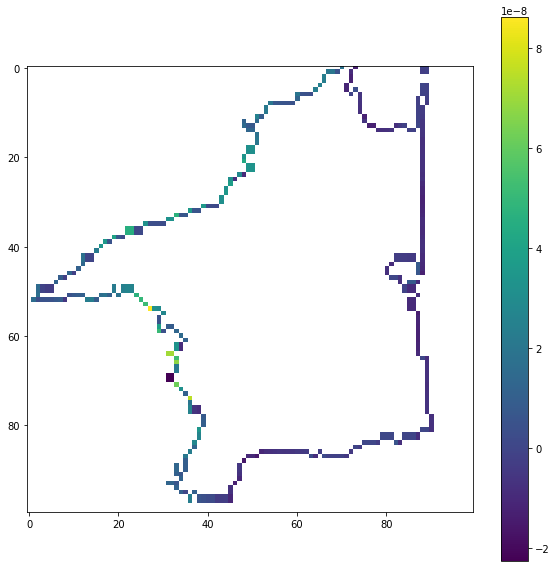

In [4]:
nrow = ncol = 100
dc = (Lx/ncol)
dr = (Ly/nrow)
delc = np.ones(nrow)*dc
delr = np.ones(ncol)*dr

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)
Qlim_resample=Qlim.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Qlim.bands[0],
                                method="nearest")
Qlim_resample[Qlim_resample==-999]=None
Qlim_resample/=area

fig = plt.figure(figsize=(10,10))
plt.imshow(Qlim_resample)
plt.colorbar()

In [5]:
def load_flux_bc(path,g):
    
    """
    resample a raster file to a new resolution given a certain grid, made to import the bc flux map
    """
    Qlim = Raster.load(path)
    x0,x1,y0,y1 = Qlim.bounds
    values = Qlim.get_array(1)
    #values[values==-999]=None
    nrow,ncol = values.shape
    Lx = x1-x0
    Ly = y1-y0
    dx = Lx/ncol
    dy = Ly/nrow
    area = dx*dy
    
    Qlim_resample=Qlim.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Qlim.bands[0],
                                method="nearest")
    
    Qlim_resample[Qlim_resample==-999]=None
    return Qlim_resample/area

In [6]:
# quick code to read all the grd files in a given folder and store the path in a list
folder_path = "../data/flux_lim"
lst_files =[]
for file in glob.glob(os.path.join(folder_path, '*.grd')):
    lst_files.append(file)

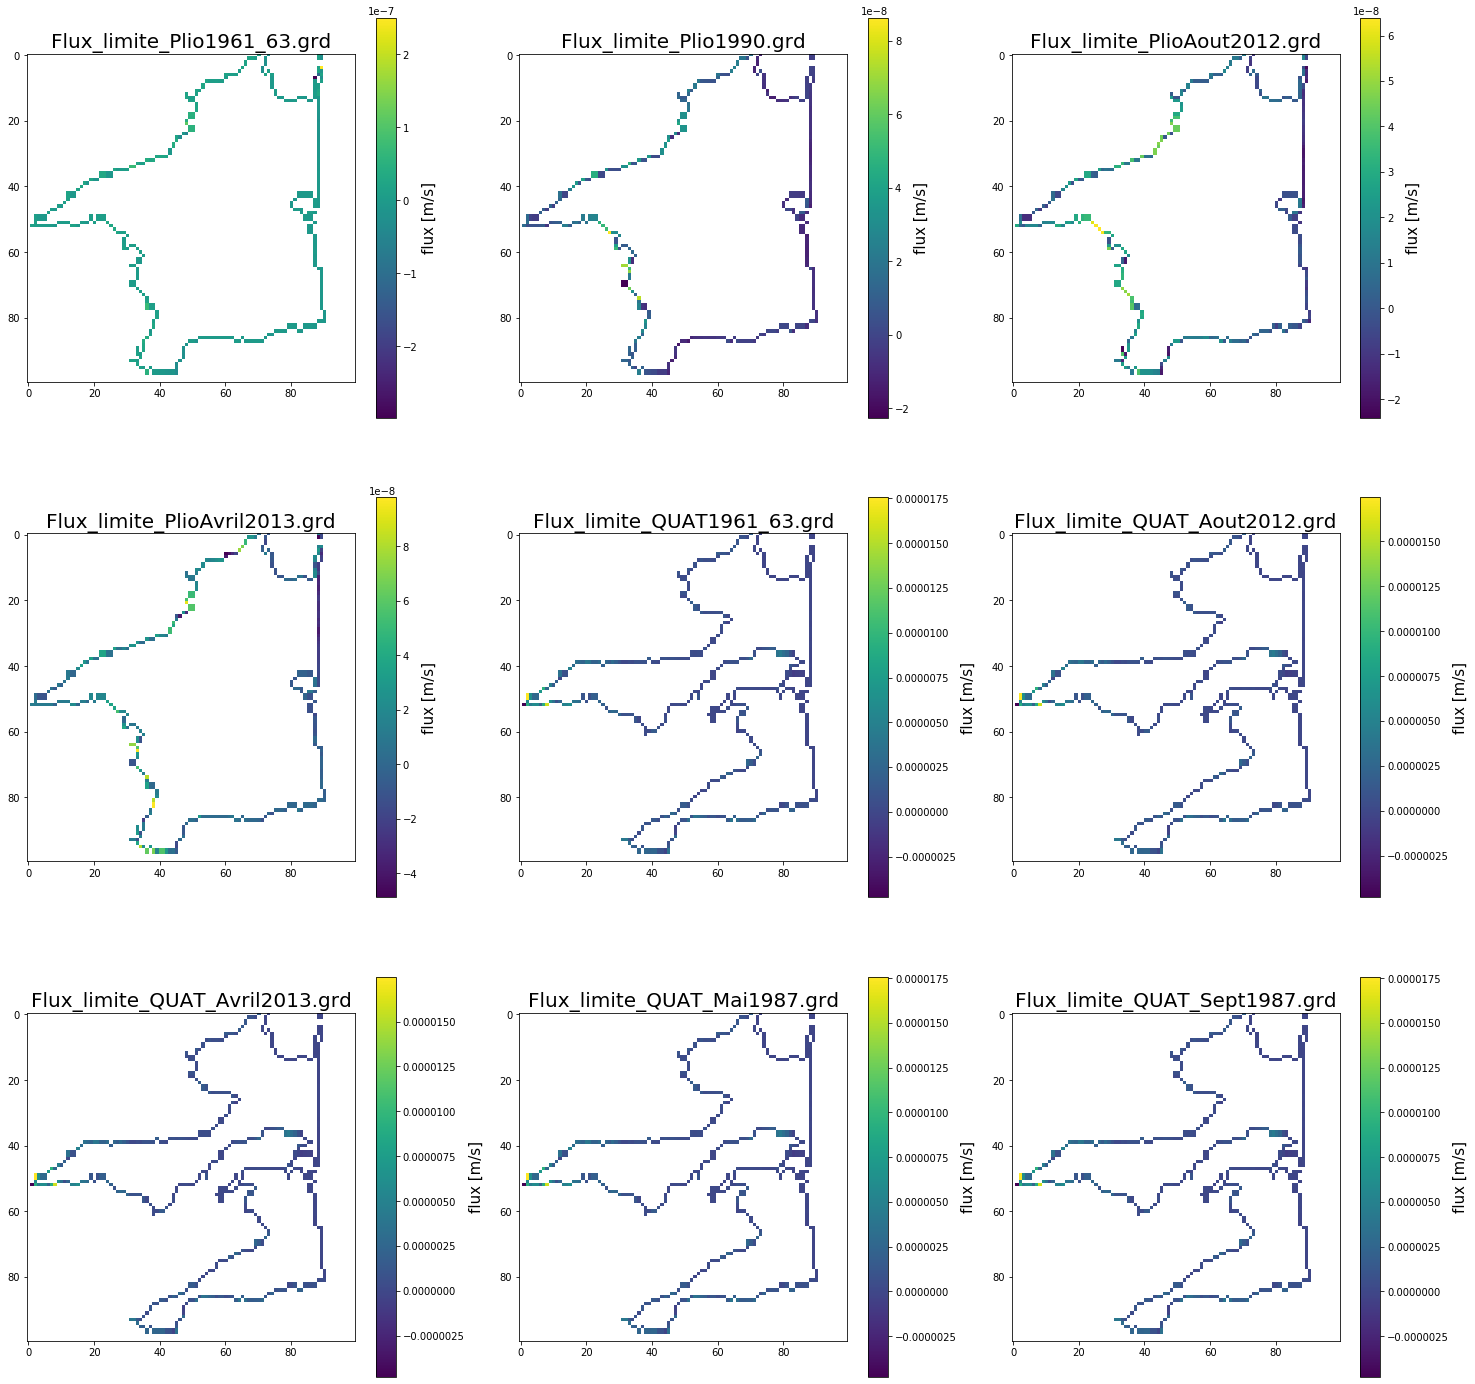

In [7]:
fig = plt.figure(figsize=(25,25))
o=0
for i in lst_files:
    o +=1
    plt.subplot(3,3,o)   
    plt.imshow(load_flux_bc(i,grid))
    plt.title(i.split(sep="\\")[-1],fontsize=20)
    g=plt.colorbar();g.set_label("flux [m/s]",fontsize=15)

In [8]:
model_dir = "working"
model_name = "flux_bc"
exe_name= "../../exe/mf6"
MNT_path= "../../data/MNT/MNT_50.tif"
R_path="../../data/shp/limitePlaineFlux.shp"

In [9]:
# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = get_MNTbbox(MNT_path)
x1 += 4000

Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = nrow = 100
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -50
top = 10. # if no mnt is provided
idomain = np.zeros((nrow*ncol))

In [10]:
# load top data
MNT = Raster.load(MNT_path)
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

top = dem_data = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

In [11]:
R = gp.read_file(R_path) # import shapefile with geopandas

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=0) # all the cells of the model

In [12]:
### BC sea

# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [13]:
## bc flux
flux = "../data/flux_lim/Flux_limite_PlioAout2012.grd"
Q_bc=load_flux_bc(flux,grid)
Q_bc[np.isnan(Q_bc)]=0
#plt.imshow(Q_bc,extent=[x0,x1,y0,y1])


In [14]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# nodeflowproperty
kh = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)

# recharge
mm = 120/1000/365/86400
#rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = mm/1000/365/86400)

# flux boundaries
rch = fp.mf6.ModflowGwfrcha(gwf, recharge = mm+Q_bc,pname="rch")

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

In [15]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model flux_bc...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rch...
    writing package oc...
    writing package sea...


In [16]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

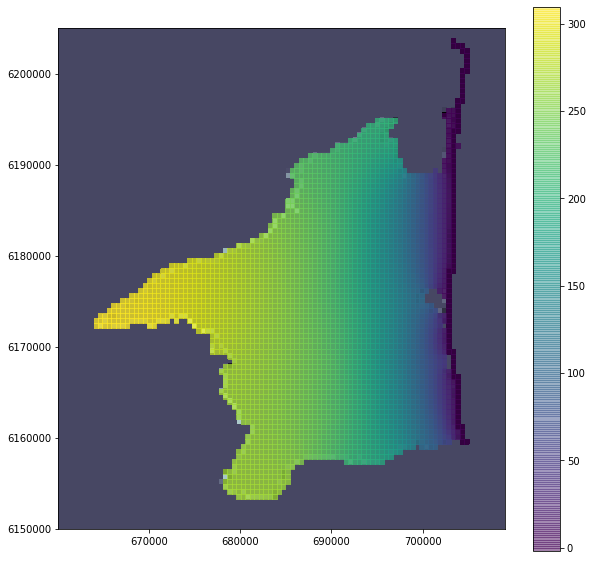

In [17]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)

# make a plot
fig = plt.figure(figsize=(10,10))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

# hmesh=ml.plot_ibound()


ml.plot_bc("sea")
ax.imshow(Q_bc,extent=[x0,x1,y0,y1],cmap="bone")
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis",alpha=0.5)
fig.colorbar(hmesh)